In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

- input_size：输入节点特征的维度。这里需要注意的是，如果你输入的是节点的交通流量数据，一般只使用一个值表示，那么你的input_size为1；若是想基于该节点在t时刻的多个特征，如：流量、速度、车辆数这三个指标对交通流量进行预测，这是input_size=3。

- hidden_size：隐藏层数，也就是可调参数。该值决定了模型的预测效果，计算复杂度。

- num_layers：堆叠的GRU的层数，num_layers=2说明堆叠了两层GRU，第一层GRU输出的隐藏特征h会作为第二层GRU的数据再进行一次计算。

- batch_first：主要为了规范输入数据各个维度所代表的含义。这里其实只需要记住一种情况即可，batch_first=True代表输入数据的三个维度分别代表input(batch_size, seq_len, input_size)，输出数据的三个维度分别代表output(batch_size, seq_len, num_directions * hidden_size)。

- bidirectional：bidirectional=True代表双向GRU，在计算时，GRU不仅按从0到t的顺序对数据进行计算，还会按照从t到0的顺序对数据进行二次计算。

注：这里需要注意input_size和seq_len的区别，input_size代表某个时间t，节点特征的维度；seq_len则代表你要基于多长的历史数据对未来的数据状态进行预测。

/var/folders/1g/xjwtls9s647d873qm80p2v5c0000gn/T/ipykernel_34487/3158734923.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = [load[j]]
/var/folders/1g/xjwtls9s647d873qm80p2v5c0000gn/T/ipykernel_34487/3158734923.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_label.append(load[i + 6])
/var/folders/1g/xjwtls9s647d873qm80p2v5c0000gn/T/ipykernel_34487/3158734923.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x =

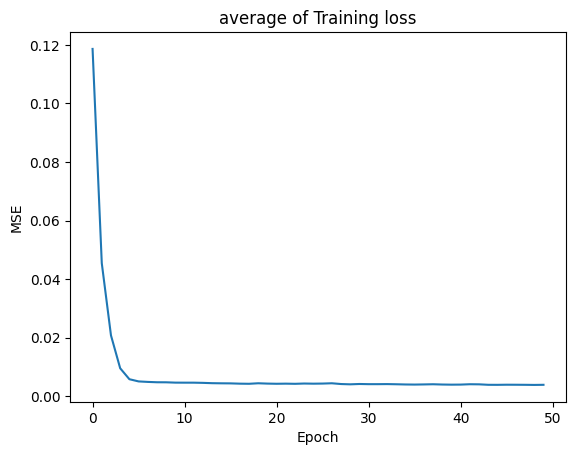

MSE: tensor(2.7932e+19, grad_fn=<MseLossBackward0>)


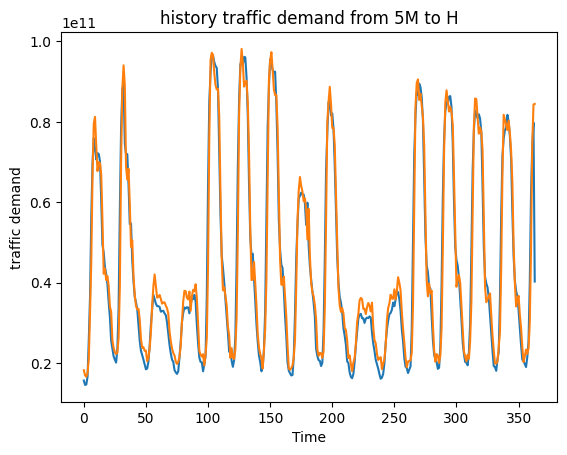

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
value = pd.read_csv(r'A5M.txt', header=None)#(14772, 1)
time = pd.date_range(start='200411190930', periods=len(value), freq='5min')
ts = pd.Series(value.iloc[:, 0].values, index=time)
ts_sample_h = ts.resample('H').sum()
# plt.plot(ts_sample_h)
# plt.xlabel("Time")
# plt.ylabel("traffic demand")
# plt.title("resample history traffic demand from 5M to H")
# plt.show()
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)

def nn_seq_us(B):
    dataset = ts_sample_h
    # split
    train = dataset[:int(len(dataset) * 0.7)]
    test = dataset[int(len(dataset) * 0.7):]
    m, n = np.max(train.values), np.min(train.values)
    # print(m,n)

    def process(data, batch_size, shuffle):
        load = data
        load = (load - n) / (m - n)
        seq = []
        for i in range(len(data) - 6):
            train_seq = []
            train_label = []
            for j in range(i, i + 6):
                x = [load[j]]
                train_seq.append(x)
            train_label.append(load[i + 6])
            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=shuffle, num_workers=0, drop_last=False)

        return seq

    Dtr = process(train, B, False)
    Dte = process(test, B, False)

    return Dtr, Dte, m, n

class GRU(torch.nn.Module):
    def __init__(self, hidden_size, num_layers):
        super().__init__()
        self.input_size = 1
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = 1
        self.num_directions = 1
        self.gru = torch.nn.GRU(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = torch.nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq):
        batch_size, seq_len = input_seq.shape[0], input_seq.shape[1]
        h_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        # output(batch_size, seq_len, num_directions * hidden_size)
        output, _ = self.gru(input_seq, (h_0))
        pred = self.linear(output)
        pred = pred[:, -1, :]
        return pred

Dtr, Dte, m, n= nn_seq_us(64)
hidden_size, num_layers = 10, 2
model = GRU(hidden_size, num_layers).to(device)
loss_function = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1.5e-3)

# training
trainloss_list = []
model.train()
for epoch in tqdm(range(50)):
    train_loss = []
    for (seq, label) in Dtr:
        seq = seq.to(device)#torch.Size([64, 80, 1])
        label = label.to(device)#torch.Size([64, 1])
        y_pred = model(seq)
        loss = loss_function(y_pred, label)
        train_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    trainloss_list.append(np.mean(train_loss))
# training_loss的图
plt.plot(trainloss_list)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("average of Training loss")
plt.show()


pred = []
y = []
model.eval()
for (seq, target) in Dte:
    seq = seq.to(device)
    target = target.to(device)
    y_pred = model(seq)
    pred.append(y_pred)
    y.append(target)


y=torch.cat(y, dim=0)
pred=torch.cat(pred, dim=0)
y = (m - n) * y + n
pred = (m - n) * pred + n#torch.Size([179, 1])
print('MSE:', loss_function(y, pred))
# plot
plt.plot(y.cpu().detach().numpy(), label='ground-truth')
plt.plot(pred.cpu().detach().numpy(), label='prediction')
plt.xlabel("Time")
plt.ylabel("traffic demand")
plt.title("history traffic demand from 5M to H")
plt.show()


官方API：
https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM

参数
– input_size
– hidden_size
– num_layers
– bias
– batch_first
– dropout
– bidirectional
输入
– input (seq_len, batch, input_size)
– h_0 (num_layers * num_directions, batch, hidden_size)
– c_0 (num_layers * num_directions, batch, hidden_size)
输出
– output (seq_len, batch, num_directions * hidden_size)
– h_n (num_layers * num_directions, batch, hidden_size)
– c_n (num_layers * num_directions, batch, hidden_size)

/var/folders/1g/xjwtls9s647d873qm80p2v5c0000gn/T/ipykernel_34487/4237114461.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = [load[j]]
/var/folders/1g/xjwtls9s647d873qm80p2v5c0000gn/T/ipykernel_34487/4237114461.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_label.append(load[i + 6])
/var/folders/1g/xjwtls9s647d873qm80p2v5c0000gn/T/ipykernel_34487/4237114461.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x =

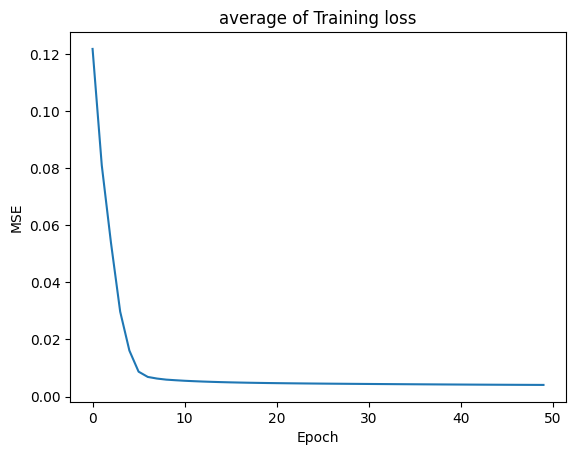

/Users/zhangxiaoyu/miniconda3/envs/py10/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([364, 2])) that is different to the input size (torch.Size([364, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE: tensor(2.9556e+19, grad_fn=<MseLossBackward0>)


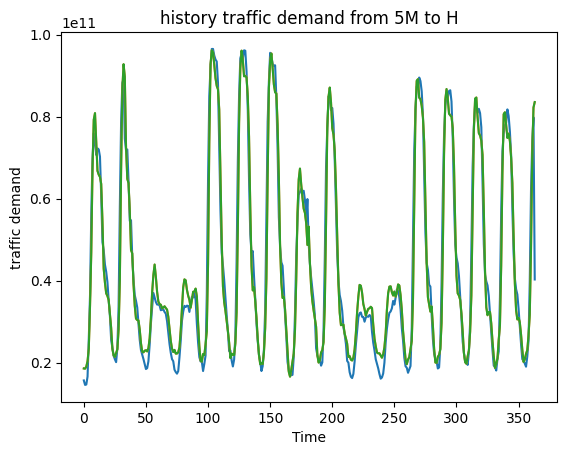

In [3]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
value = pd.read_csv(r'A5M.txt', header=None)#(14772, 1)
time = pd.date_range(start='200411190930', periods=len(value), freq='5min')
ts = pd.Series(value.iloc[:, 0].values, index=time)
ts_sample_h = ts.resample('H').sum()
# plt.plot(ts_sample_h)
# plt.xlabel("Time")
# plt.ylabel("traffic demand")
# plt.title("resample history traffic demand from 5M to H")
# plt.show()
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)

def nn_seq_us(B):
    dataset = ts_sample_h
    # split
    train = dataset[:int(len(dataset) * 0.7)]
    test = dataset[int(len(dataset) * 0.7):]
    m, n = np.max(train.values), np.min(train.values)
    # print(m,n)

    def process(data, batch_size, shuffle):
        load = data
        load = (load - n) / (m - n)
        seq = []
        for i in range(len(data) - 6):
            train_seq = []
            train_label = []
            for j in range(i, i + 6):
                x = [load[j]]
                train_seq.append(x)
            train_label.append(load[i + 6])
            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=shuffle, num_workers=0, drop_last=False)

        return seq

    Dtr = process(train, B, False)
    Dte = process(test, B, False)

    return Dtr, Dte, m, n

class LSTM(torch.nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.input_size = 1
        self.hidden_size = hidden_size
        self.num_layers = 1
        self.output_size = output_size
        self.num_directions = 1 # 单向LSTM
        self.lstm = torch.nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.lin = torch.nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq):
        batch_size, seq_len = input_seq.shape[0], input_seq.shape[1]
        # input(batch_size, seq_len, input_size)
        h_0 = torch.zeros(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        # output(batch_size, seq_len, num_directions * hidden_size)
        output, _ = self.lstm(input_seq, (h_0.detach(), c_0.detach())) 
        pred = output[:, -1, :]
        pred = self.lin(pred)
        return pred

Dtr, Dte, m, n= nn_seq_us(64)
hidden_size, num_layers = 10, 2
model = LSTM(hidden_size, num_layers).to(device)
loss_function = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1.5e-3)

# training
trainloss_list = []
model.train()
for epoch in tqdm(range(50)):
    train_loss = []
    for (seq, label) in Dtr:
        seq = seq.to(device)#torch.Size([64, 80, 1])
        label = label.to(device)#torch.Size([64, 1])
        y_pred = model(seq)
        loss = loss_function(y_pred, label)
        train_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    trainloss_list.append(np.mean(train_loss))
# training_loss的图
plt.plot(trainloss_list)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("average of Training loss")
plt.show()


pred = []
y = []
model.eval()
for (seq, target) in Dte:
    seq = seq.to(device)
    target = target.to(device)
    y_pred = model(seq)
    pred.append(y_pred)
    y.append(target)


y=torch.cat(y, dim=0)
pred=torch.cat(pred, dim=0)
y = (m - n) * y + n
pred = (m - n) * pred + n#torch.Size([179, 1])
print('MSE:', loss_function(y, pred))
# plot
plt.plot(y.cpu().detach().numpy(), label='ground-truth')
plt.plot(pred.cpu().detach().numpy(), label='prediction')
plt.xlabel("Time")
plt.ylabel("traffic demand")
plt.title("history traffic demand from 5M to H")
plt.show()
